In [239]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [233]:
import re
import nltk
from nltk.corpus import stopwords

# Stemmer will reduce words in their root form
# from nltk.stem.porter import PorterStemmer
# ps = PorterStemmer()
# stopwords = stopwords.words('english')

# # Removing some stopwords which have significance effect in building this model
# rem = ['not', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', 
#        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', 
#        "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'don', "don't", 
#        'just', 'too', 'very', 'no', 'nor', 'only', 'own', 'same', 'again', 'against', 'but']
# for s in rem:
#     stopwords.remove(s)

In [3]:
embeddings_index = {}
GLOVE_DIR = "C:/Users/Rif010/Desktop/Rian vai try/"
f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [218]:
import string
def clean_text(text):
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text
    

In [234]:
from nltk.tokenize import word_tokenize

def tokenize(data2):
    clean_reviews = list()
    reviews = data2["Sar_Reviews"].values.tolist()
    for review in reviews:
        review = clean_text(review)
        # tokenize the text
        tokens = word_tokenize(review)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
#         remove stop words
        words = [w for w in words if not w in stop_words]
        clean_reviews.append(words)
    return clean_reviews

In [227]:
reviews = tokenize(data2)

[['purchased',
  'back',
  'april',
  'used',
  'right',
  'away',
  'remote',
  'put',
  'remaining',
  'cabinet',
  'last',
  'night',
  'months',
  'later',
  'went',
  'replace',
  'batteries',
  'another',
  'remote',
  'dead',
  'purchased',
  'another',
  'box',
  'batteries',
  'local',
  'store',
  'installed',
  'remote',
  'remote',
  'worked',
  'great',
  'definitely',
  'quality',
  'issue',
  'batteries',
  'based',
  'reviews'],
 ['liked',
  'first',
  'except',
  'browser',
  'kind',
  'clunky',
  'also',
  'use',
  'android',
  'apps',
  'worst',
  'thing',
  'though',
  'mine',
  'just',
  'stopped',
  'working',
  'middle',
  'watching',
  'movie',
  'long',
  'plane',
  'flight',
  'fully',
  'charged',
  'tried',
  'recharging',
  'turning',
  'etc',
  'just',
  'blank',
  'screen',
  'kind',
  'cool',
  'paperweight',
  'hope',
  'get',
  'money',
  'back',
  'get',
  'new',
  'one']]

(-0.5, 999.5, 499.5, -0.5)

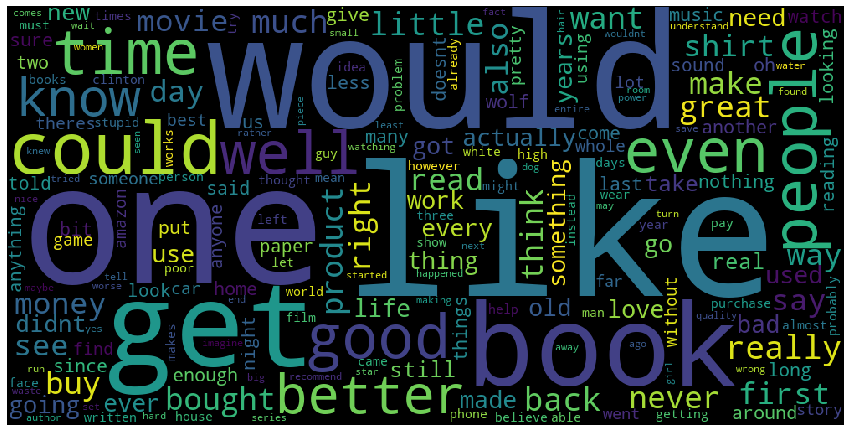

In [235]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data2.loc[data2['sarcastic'] == 1]
pos_head_lines = tokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [237]:
###''''''Train

In [252]:
validation_split = 0.20
max_length = 140


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(reviews)
sequences = tokenizer_obj.texts_to_sequences(reviews)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
#print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data2['sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  7051


In [253]:
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

6773


In [254]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [255]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.20, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())


Summary of the built model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 140, 300)          2115600   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,209,105
Trainable params: 93,505
Non-trainable params: 2,115,600
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train_pad, y_train, batch_size=128, epochs=5, validation_data=(X_test_pad, y_test), verbose=2)

In [260]:
###nayeb bayes

In [261]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train_pad, y_train)

MultinomialNB()

In [275]:
from sklearn.metrics import confusion_matrix, accuracy_score

print('(Nayeb Bayes) Result on training set :')
print('Confusion matrix :')
print(confusion_matrix(y_train,classifier.predict(X_train_pad)))
print('accuracy : ',accuracy_score(y_train, classifier.predict(X_train_pad)))

print('Result on test set :')
y_pred = classifier.predict(X_test_pad)
print('Confusion matrix :')
print(confusion_matrix(y_test, y_pred))
print('accuracy',accuracy_score(y_test, y_pred))

(Nayeb Bayes) Result on training set :
Confusion matrix :
[[453  32]
 [261 134]]
accuracy :  0.6670454545454545
Result on test set :
Confusion matrix :
[[97 17]
 [64 42]]
accuracy 0.6318181818181818


In [265]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multioutput import ClassifierChain

In [263]:
###Random Forest

In [272]:

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_pad,y_train)

RandomForestClassifier()

In [276]:
print('Result Random Forest (Training) :')
print('Confusion matrix :')
print(confusion_matrix(y_train,clf.predict(X_train_pad)))
print('accuracy : ',accuracy_score(y_train, clf.predict(X_train_pad)))

print('Result on test set :')
y_pred = clf.predict(X_test_pad)
print('Confusion matrix :')
print(confusion_matrix(y_test, y_pred))
print('accuracy',accuracy_score(y_test, y_pred))

Result Random Forest (Training) :
Confusion matrix :
[[485   0]
 [  0 395]]
accuracy :  1.0
Result on test set :
Confusion matrix :
[[101  13]
 [ 13  93]]
accuracy 0.8818181818181818


In [278]:
###SVC

In [279]:
svc = SVC()
svc.fit(X_train_pad,y_train)

SVC()

In [280]:
print('(SVC)Result on training set :')
print('Confusion matrix :')
print(confusion_matrix(y_train,svc.predict(X_train_pad)))
print('accuracy : ',accuracy_score(y_train, svc.predict(X_train_pad)))

print('Result on test set :')
y_pred = svc.predict(X_test_pad)
print('Confusion matrix :')
print(confusion_matrix(y_test, y_pred))
print('accuracy',accuracy_score(y_test, y_pred))

(SVC)Result on training set :
Confusion matrix :
[[478   7]
 [ 50 345]]
accuracy :  0.9352272727272727
Result on test set :
Confusion matrix :
[[106   8]
 [ 17  89]]
accuracy 0.8863636363636364


In [282]:
X_train_pad

array([[  13,  123,   10, ...,    0,    0,    0],
       [  87, 1874, 4231, ...,    0,    0,    0],
       [ 160, 3156, 1400, ...,    0,    0,    0],
       ...,
       [6298, 6299, 2843, ...,    0,    0,    0],
       [   5,   39,  579, ...,    0,    0,    0],
       [  13,   89,  618, ...,    0,    0,    0]])

In [302]:
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
from scipy import sparse
wordnet_lemmatizer = WordNetLemmatizer()

In [303]:
def cleantokenize(review):
    ret_str = ""
    review = clean_text(review)
    # tokenize the text
    tokens = word_tokenize(review)
    lem = [wordnet_lemmatizer.lemmatize(t,'n') for t in tokens]
    for t in lem:
        ret_str += t
        ret_str += " "
    return ret_str

In [306]:
reviews = data2["Sar_Reviews"]
clean_sen = [cleantokenize(review) for review in reviews]
vectorizer = TfidfVectorizer()
vectorizer.fit(clean_sen)
print(len(vectorizer.vocabulary_))

6686


In [309]:
validation_split = 0.2
num_validation_samples = int(validation_split * len(clean_sen))

X_train_pad = clean_sen[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = clean_sen[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

In [311]:
X_train_pad = vectorizer.transform(X_train_pad)